#Analyzing the NYC Subway Dataset

In this project we are analyzing NYC Subway Data and Weather Underground data to find out impact of rainy days on NYC Subway Ridership. 

We wrangle NYC Subway data from May, 2011. It contains hourly entries and exits to turnstiles in the subway system. Sample data can be found in below link:
http://web.mta.info/developers/data/nyct/turnstile/turnstile_110507.txt
Files for multiple days are combined and cleaned.

Weather data for NYC for May, 2011 from [Weather Underground](http://www.wunderground.com/?MR=1) is joined to get rain, fog, pressure, precipitation, thunder and other data elements.

We load joined and cleaned dataset to pandas dataframes from csv file.

In [1]:
import pandas as pd

turnstile_weather = pd.read_csv('turnstile_data_master_with_weather.csv')
turnstile_weather.head()


,Unnamed: 0,UNIT,DATEn,TIMEn,Hour,DESCn,ENTRIESn_hourly,EXITSn_hourly,maxpressurei,maxdewpti,...,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
0,0,R001,2011-05-01,01:00:00,1,REGULAR,0,0,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
1,1,R001,2011-05-01,05:00:00,5,REGULAR,217,553,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
2,2,R001,2011-05-01,09:00:00,9,REGULAR,890,1262,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
3,3,R001,2011-05-01,13:00:00,13,REGULAR,2451,3708,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
4,4,R001,2011-05-01,17:00:00,17,REGULAR,4400,2501,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0


## Section 0. References

Yhat GGPlot:  
http://ggplot.yhathq.com/docs/index.html  
http://blog.yhathq.com/posts/ggplot-0.4-released.html

Descriptive Statistics:  
https://www.udacity.com/course/intro-to-descriptive-statistics--ud827  
http://www.statsoft.com/Textbook/Multiple-Regression#cresidual

Mann-Whitney U-Test  
http://wikiofscience.wikidot.com/technology1:mann-whitney-u-test  
http://www.graphpad.com/guides/prism/6/statistics/index.htm?how_the_mann-whitney_test_works.htm   



## Section 1. Statistical Test

   ### 1.1 Statistical Testing : Mann-Whitney U-Test
   We will use Mann-Whitney U-Test to analyze this data. Two-tailed P-value will be used.
   Scipy.stats implementation of Mann-Whitney U-test returns one tailed P-value. So we will multiply it by 2 to get two-tailed P-value.
   
   P-Critical value used in this test 0.05.
   
   ### 1.2 Statistical Test Applicability
   Mann-Whitney U-Test  tests null hypothesis that two samples come from same population. Also, one of the assumptions to use this test is that we have independence of observations for our datasets.
     
   Our dataset statisfy these assumptions. We will use this test by dividing complete dataset into two dataframes:
   Entries with Rain and Entries without Rain
   And there will be no overlap in above datasets.
   
   In Section 3.1, we can see that our datasets are not normally distributed, which make them appropirate for Mann-Whitney U-test.
   
   ### 1.3 Statistical Test Results
   Statistical Test Results for Mann-Whitney tests are below.  

In [2]:
import numpy as np

df_rain = turnstile_weather[turnstile_weather.rain == 1].ENTRIESn_hourly
df_no_rain = turnstile_weather[turnstile_weather.rain == 0].ENTRIESn_hourly

with_rain_mean = np.mean(df_rain)
without_rain_mean = np.mean(df_no_rain)

print('Mean Hourly Entries With Rain: {}'.format(with_rain_mean))
print('Mean Hourly Entries Without Rain: {}'.format(without_rain_mean))

Mean Hourly Entries With Rain: 1105.4463767458733
Mean Hourly Entries Without Rain: 1090.278780151855


In [3]:
import scipy
import scipy.stats

U, p = scipy.stats.mannwhitneyu(df_rain, df_no_rain)

print('Mann Whitney Test Statistic: {}'.format(U))
print('P-value: {}'.format(p))

Mann Whitney Test Statistic: 1924409167.0
P-value: 0.019309634413792565


  ### 1.4 Significance of Test Results  

In [28]:
p_critical = 0.05
two_tailed_p = p * 2
print('Two tailed p-value: ' +str(two_tailed_p))

if two_tailed_p < p_critical:
    print('Reject the Null Hypothesis')
else:
    print('Fail to Reject Null Hypothesis')

Two tailed p-value: 0.0386192688276
Reject the Null Hypothesis


  Since two tailed p-value (0.039) is less than p-critical, we reject the null hypothesis.
  We interpret the test results that, with and without rains hourly/entries are statistically different.

# Section 2. Linear Regression
 
 ### 2.1 Prediction of Hourly Ridership
 We will use Ordinary Least Squares (OLS) to compute coefficients theta and produce prediction for Linear Regression Model.
 Python statsmodel api will be used for OLS.
 
 ### 2.2 Features for Regression Model
 The following features are selected :
 - rain
 - precipi
 - Hour
 - meanteampi
 - maxtempi
 - fog
 
 Pandas get_dummies is used to convert UNIT categorical data into dummy variable.
 

In [31]:
features = turnstile_weather[['rain', 'precipi', 'Hour', 'meantempi', 'mintempi', 'maxtempi', 'fog']]

# Dummy variable 
dummy_units = pd.get_dummies(turnstile_weather['UNIT'], prefix='unit')
#features = features.join(dummy_units)

 ### 2.3 Features Selection Rationale
 
Weather conditions like rain, precipi, meantempi, maxtempi, meantempi, fog are selected as features. These weather conditions potentially impact ridership. Weather affects people's decisions to stay indoor or to take subway for commute. If temp is too high or low, people will  feel more comfortable riding subway.
 
Hour is selected because if it is office hours/rush hours ridership will be high.

Unit is selected because different stations can have different ridership.
 

 ### 2.4 Coefficients of the non-dummy Features
  Calculating coefficients of the non-dummy features.

In [32]:
import statsmodels.api as sm

# Values
values = turnstile_weather['ENTRIESn_hourly']

features = sm.add_constant(features)
model = sm.OLS(values, features)
results = model.fit()
intercept = results.params[0]
params = results.params[1:]

#print('Coefficients {}'.format(params))
print(params)

rain         -21.561338
precipi       20.116247
Hour          59.502082
meantempi   -125.380279
mintempi      44.676908
maxtempi      69.570961
fog          139.468526
dtype: float64


 ### 2.5 R-Squared - Coefficients of Determination
 R^2 is caluclated as below
/ R^2 = 0.47924770782

In [ ]:

features = features.join(dummy_units)

features = sm.add_constant(features)
model = sm.OLS(values, features)
results = model.fit()
intercept = results.params[0]
params = results.params[1:]

predictions = intercept + np.dot(features, params)

numer = ((values - predictions)**2).sum()
denom = ((values - np.mean(values))**2).sum()

r_squared = 1 - numer/denom
print(r_squared)

### 2.6 Goodness of Regression Model

Our R^2 value is 0.48, which means we have explained 48% of variability and we are still left with 52% of residual variability.
Ideally, we would like to explain most if not all of the original variability. 

The R^2 value is an indicator of how well the model fits the data. Higher the R^2 value towards the 1, better the model fits the data. So, linear model is probably inappropriate given this low R^2 value.

Due to categorical nature of data Linear model may not be better fit.

# Section 3. Visualization

 ### 3.1 Histogram of ENTRIESn_hourly distribution  


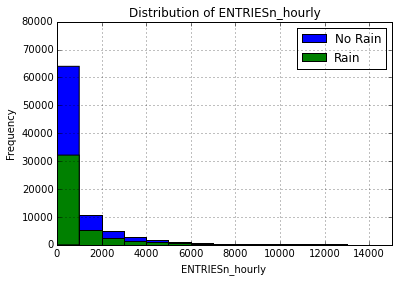

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline 

num_bins = 30
start_bin = min(turnstile_weather['ENTRIESn_hourly'])
stop_bin = max(turnstile_weather['ENTRIESn_hourly'])
bin_width = 1000 #(stop_bin - start_bin)/num_bins

bin_list = np.arange(start_bin, stop_bin, bin_width)


hist_plot = turnstile_weather[turnstile_weather.rain==0].ENTRIESn_hourly.plot(kind='hist', label='No Rain', bins = bin_list)
hist_plot = turnstile_weather[turnstile_weather.rain==1].ENTRIESn_hourly.plot(kind='hist', label='Rain', bins = bin_list)

hist_plot.legend()
hist_plot.set_ylabel('Frequency')
hist_plot.set_xlabel('ENTRIESn_hourly')
hist_plot.set_title('Distribution of ENTRIESn_hourly')
plt.axis([0,15000,0,80000])
plt.show()

Distribution for ENTRIESn_hourly ridership is plotted using matplotlib.pyplot. We can see distribution is not normally distributed. Observations on rainy days are less than non-rainy days.

  ### 3.2 Ridership Group by Days-of-Week
 

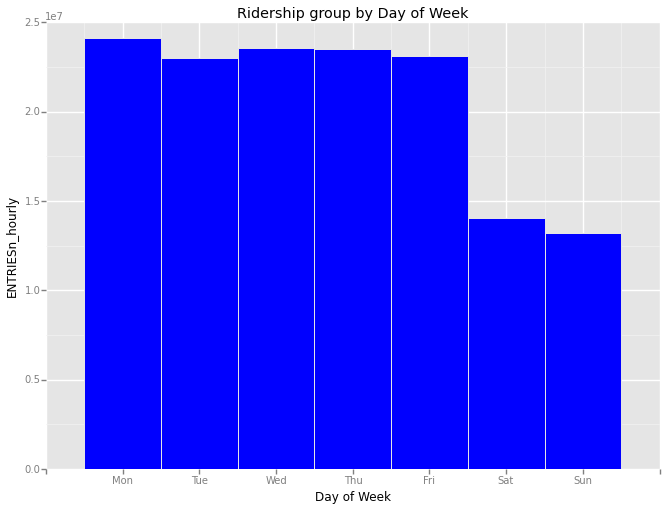

<ggplot: (-9223372036839435569)>

In [29]:
from ggplot import *
%matplotlib inline

pd.options.mode.chained_assignment = None

df = turnstile_weather[['DATEn', 'ENTRIESn_hourly']]
df['DATEn'] = pd.to_datetime(df['DATEn'])
df['day_of_week'] = df['DATEn'].dt.dayofweek

ts = df.set_index('day_of_week')

by_day = ts.groupby(ts.index).sum()
by_day = by_day.reset_index()

ggplot(by_day, aes(x = 'day_of_week', y = 'ENTRIESn_hourly')) \
    + geom_bar(stat='bar', fill='blue', position = 'stack') + \
    ggtitle('Ridership group by Day of Week') \
     +scale_x_continuous(name="Day of Week", labels = ["","Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
    


Above plot is plotted using ggplot library. This shows Ridership by day-of-week. We can see that ridership is higher on weekdays.

# Section 4. Conclusion

 ### 4.1 Conclusion
 Based on analysis and interpretation of data, we can conclude that more people ride NYC Subway when it is raining.
 
 ### 4.2 Rationale behind Conclusion
 During our statistical test we noticed that mean of hourly entries during rain is higher that without rain.  
   
   Mean Hourly Entries With Rain: 1105.4463767458733  
   Mean Hourly Entries Without Rain: 1090.278780151855  
   
 Also, we saw two tailed p-value was less than p-critical. We interpreted that hourly/entries with and without rains are statistically different.

# Section 5. Reflection

 ### 5.1 Shortcomings of Dataset or methods of the analysis
 The dataset is limited for only one month of ridership data (May 2011). We cannot consider our conclusion as perfect because of smaller dataset and impact of season on the particular month.
 
Other weather conditions can also have impact on ridership which was not considered.

Another shortcomings in our dataset is that we have joined hourly ridership data with daily weather data.
 
R^2 is still at lower side which means our regression model may not be better fit for data.